# Gaussian Process

## 0. Initialize

In [1]:
#mathematics
using LinearAlgebra

#statistics
using Random
using Distributions
using Statistics

#visualize
using Plots
pyplot()

#macros
using ProgressMeter
using UnPack

## 1. Linear regression

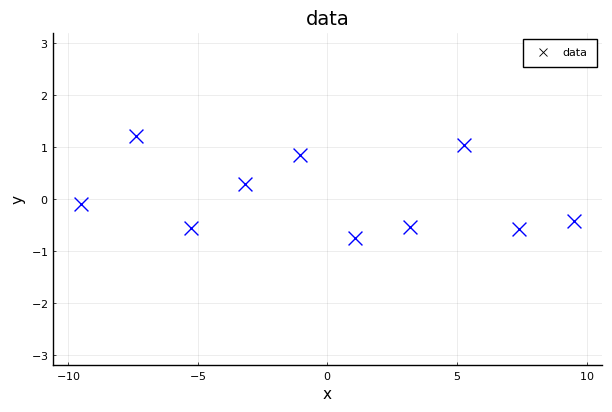

In [2]:
#sample X and Y
Random.seed!(7)
F(x) = (-sin(2*x)+cos(3*x))+1
N = 10
X = shuffle(range(-10+0.5,10-0.5,length=N))
Y = F.(X) + 0.3*randn(N)
data = (X=X,Y=Y,N=N)

#plot the data
fig1 = plot(X, Y, st=:scatter, xlabel="x", ylabel="y", title="data", label="data", xlim=[-10,10], ylim=[-3,3],
    markershape=:x, markerstrokewidth=1, markersize=10, markercolor=:blue)
savefig(fig1, "figs-GP/fig1.png")

In [3]:
#basis function 
ϕi(x,μi,σi) = exp(-(x-μi)^2/σi/σi/2)
function ϕ(x,basis_params)
    @unpack μs,σs,dw = basis_params
    vals = ones(dw)
    for i in 1:dw-1
        vals[i+1] = ϕi(x,μs[i],σs[i])
    end
    return vals
end

#design matrix
function design_matrix(X,N,dw,basis_params)
    mat = zeros(N,dw)
    for n in 1:N
        mat[n,:] = ϕ(X[n],basis_params)
    end
    return mat
end

#model
f(x,wvec,params) = dot(wvec, ϕ(x,params))

#Bayesian inference
function Bayes_pred(xs, data, model_params, basis_params)
    @unpack X,Y,N = data
    @unpack σ,λw,dw = model_params
    npred = length(xs)
    μpred = zeros(npred)
    σpred = zeros(npred)
    Φ = design_matrix(X,N,dw,basis_params)
    ΦTΦ = Φ' * Φ
    ΦTy = Φ' * Y
    ϕx = zeros(dw)
    mat = zeros(dw,dw)
    for n in 1:npred
        ϕx = ϕ(xs[n],basis_params)
        mat = ΦTΦ+ϕx*ϕx'+σ^2*λw*I(dw)
        μpred[n] = dot(ϕx, mat\ΦTy)/(1-dot(ϕx, mat\ϕx))
        σpred[n] = σ^2/(1-dot(ϕx, mat\ϕx))
    end
    return μpred, σpred
end

Bayes_pred (generic function with 1 method)

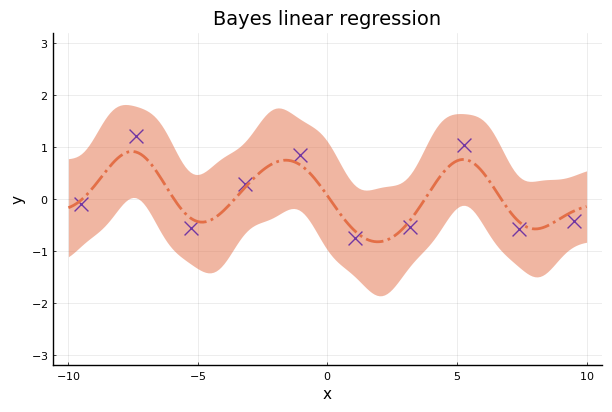

In [4]:
#define model
σ = 0.7
λw = 0.8
dw = 20
μs = -10:1:10
σs = ones(dw-1)
model_params = (σ=σ, λw=λw, dw=dw)
basis_params = (μs=μs, σs=σs, dw=dw)

#inference
xs = -10:0.1:10
μpred, σpred = Bayes_pred(xs, data, model_params, basis_params)

#visualize
fig2 = plot(X,Y,st=:scatter,xlabel="x",ylabel="y",title="Bayes linear regression",label=false,ylim=[-3,3],
    markershape=:x, markerstrokewidth=1, markersize=10, markercolor=:blue)
plot!(xs, μpred, ribbon=σpred, label=false, ls=:dashdot, lw=2)
savefig(fig2, "figs-GP/fig2.png")

## 2. Gaussian Process regression

In [5]:
#create covariance function
function GPcov(xvec, kernel_params, kernel_func)
    d = length(xvec)
    K = zeros(d,d)
    for i in 1:d
        for j in 1:d
            val = kernel_func(xvec[i], xvec[j], kernel_params)
            K[i,j] = val
            K[j,i] = val
        end
    end
    return K+1e-8*I(d)
end

#mean function
GPmean(xvec) = zeros(length(xvec))

#RBF kernel
function RBFkernel(x1, x2, kernel_params)
    @unpack θ,ρ = kernel_params
    return θ*exp(-abs(x1-x2)^2/ρ)
end

#prediction
function GPpred(xs, data, kernel_params, kernel_func)
    @unpack X,Y,N = data
    @unpack σ,λw,dw = model_params
    K = GPcov(vcat(X,xs), kernel_params, kernel_func)
    npred = length(xs)
    μpred = view(K,N+1:N+npred,1:N)*(view(K,1:N,1:N)\Y)
    Σpred = view(K,N+1:N+npred,N+1:N+npred) - view(K,N+1:N+npred,1:N)*(view(K,1:N,1:N)\view(K,1:N,N+1:N+npred))
    return μpred, Matrix(Hermitian(Σpred))
end

GPpred (generic function with 1 method)

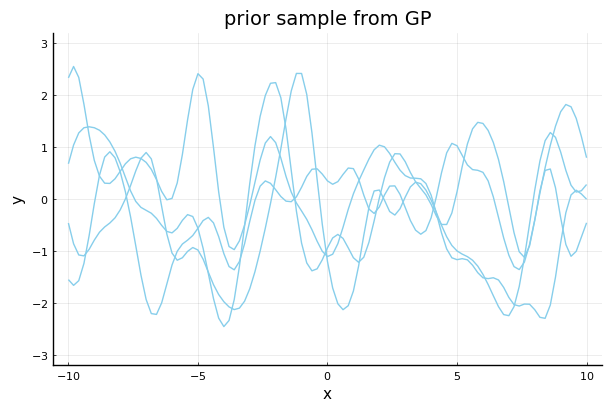

┌ Info: Saved animation to 
│   fn = /Users/kitanotomoya/Documents/julia/ML/Gaussian Process/figs-GP/anim1.gif
└ @ Plots /Users/kitanotomoya/.julia/packages/Plots/LSKOd/src/animation.jl:114


Plots.AnimatedGif("/Users/kitanotomoya/Documents/julia/ML/Gaussian Process/figs-GP/anim1.gif")
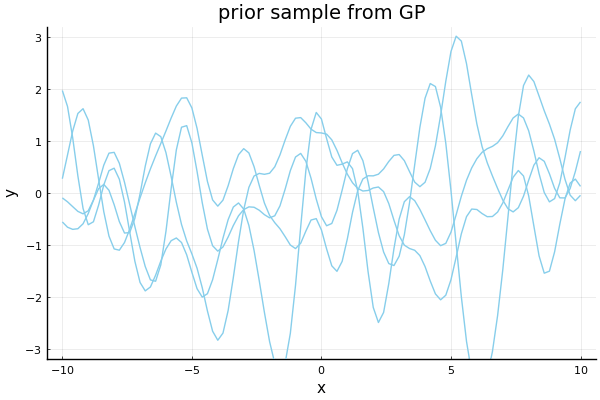

In [6]:
#define prior GP
kernel_params = (θ=1, ρ=1)
xs = -10:0.2:10
ys = xs
μvec = GPmean(xs)
K = GPcov(xs, kernel_params, RBFkernel)

Random.seed!(42)
anim1 = @animate for i in 1:10
    ys = rand(MvNormal(μvec,K))
    plot(xs, ys, xlim=[-10,10], ylim=[-3,3], label=false,color=:skyblue, 
        title="prior sample from GP", xlabel="x", ylabel="y")
    ys = rand(MvNormal(μvec,K))
    plot!(xs, ys, xlim=[-10,10], ylim=[-3,3], label=false,color=:skyblue)
    ys = rand(MvNormal(μvec,K))
    plot!(xs, ys, xlim=[-10,10], ylim=[-3,3], label=false,color=:skyblue)
    ys = rand(MvNormal(μvec,K))
    plot!(xs, ys, xlim=[-10,10], ylim=[-3,3], label=false,color=:skyblue)
end
gif(anim1, "figs-GP/anim1.gif", fps=1)

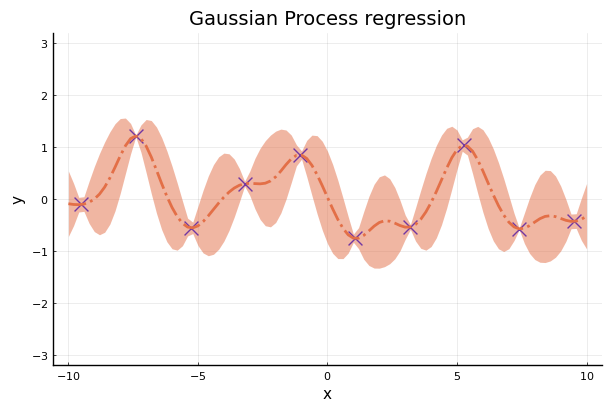

In [7]:
#define posterior GP
kernel_params = (θ=1,ρ=1)
xs = -10:0.2:10
μpred, Σpred = GPpred(xs, data, kernel_params, RBFkernel)

#visualize
fig3 = plot(X,Y,st=:scatter,xlabel="x",ylabel="y",title="Gaussian Process regression",label=false,ylim=[-3,3],
    markershape=:x, markerstrokewidth=1, markersize=10, markercolor=:blue)
plot!(xs, μpred, ribbon=sqrt.(diag(Σpred)), label=false, ls=:dashdot, lw=2)
savefig(fig3, "figs-GP/fig3.png")

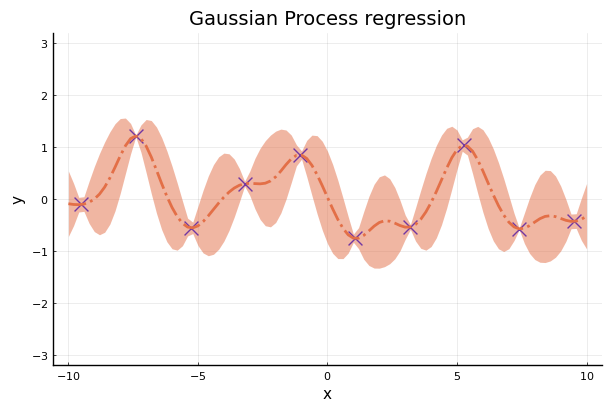

┌ Info: Saved animation to 
│   fn = /Users/kitanotomoya/Documents/julia/ML/Gaussian Process/figs-GP/anim2.gif
└ @ Plots /Users/kitanotomoya/.julia/packages/Plots/LSKOd/src/animation.jl:114


Plots.AnimatedGif("/Users/kitanotomoya/Documents/julia/ML/Gaussian Process/figs-GP/anim2.gif")
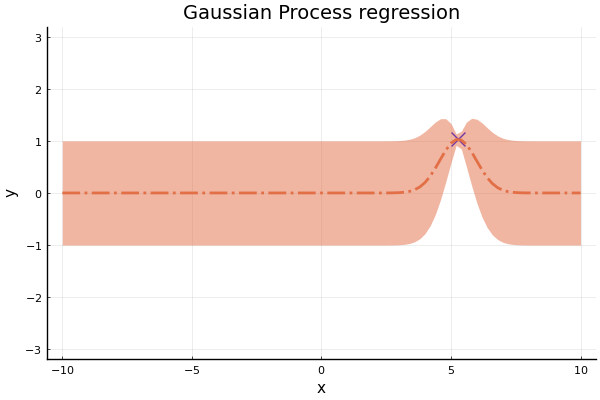

In [8]:
xs = -10:0.2:10
anim2 = @animate for n in 1:N
    datan = (X=X[1:n], Y=Y[1:n], N=n)
    μpred, Σpred = GPpred(xs, datan, kernel_params, RBFkernel)
    fig6 = plot(datan.X,datan.Y,st=:scatter,xlabel="x",ylabel="y",title="Gaussian Process regression",label=false,ylim=[-3,3],
    markershape=:x, markerstrokewidth=1, markersize=10, markercolor=:blue)
    plot!(xs, μpred, ribbon=sqrt.(diag(Σpred)), label=false, ls=:dashdot, lw=2)
end
gif(anim2, "figs-GP/anim2.gif", fps=1)

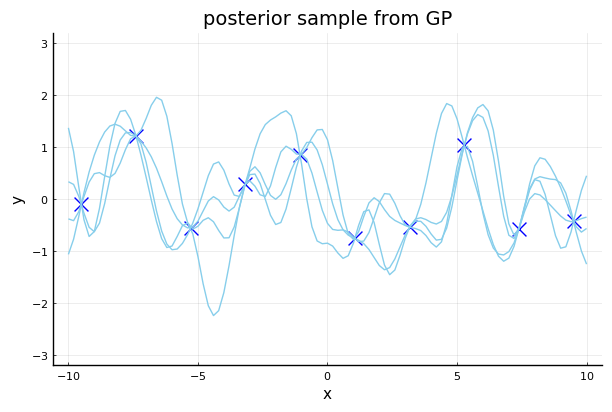

┌ Info: Saved animation to 
│   fn = /Users/kitanotomoya/Documents/julia/ML/Gaussian Process/figs-GP/anim3.gif
└ @ Plots /Users/kitanotomoya/.julia/packages/Plots/LSKOd/src/animation.jl:114


Plots.AnimatedGif("/Users/kitanotomoya/Documents/julia/ML/Gaussian Process/figs-GP/anim3.gif")
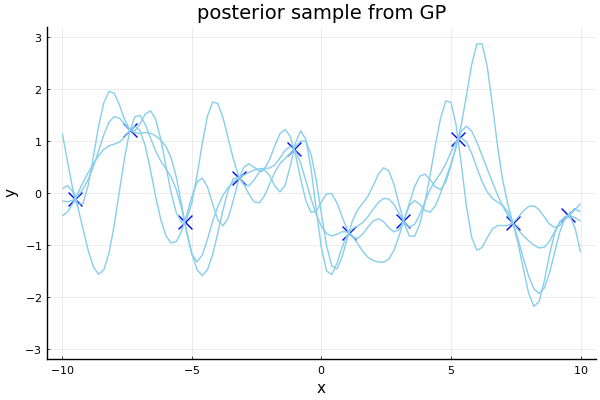

In [9]:
#define posterior GP
kernel_params = (θ=1,ρ=1)
xs = -10:0.2:10
ys = xs
μpred, Σpred = GPpred(xs, data, kernel_params, RBFkernel)

Random.seed!(42)
anim3 = @animate for i in 1:10
    plot(X,Y,st=:scatter,xlabel="x",ylabel="y",title="posterior sample from GP",label=false,ylim=[-3,3],
        markershape=:x, markerstrokewidth=1, markersize=10, markercolor=:blue, )
    ys = rand(MvNormal(μpred, Σpred))
    plot!(xs, ys, xlim=[-10,10], ylim=[-3,3], label=false, color=:skyblue)
    ys = rand(MvNormal(μpred, Σpred))
    plot!(xs, ys, xlim=[-10,10], ylim=[-3,3], label=false, color=:skyblue)
    ys = rand(MvNormal(μpred, Σpred))
    plot!(xs, ys, xlim=[-10,10], ylim=[-3,3], label=false, color=:skyblue)
    ys = rand(MvNormal(μpred, Σpred))
    plot!(xs, ys, xlim=[-10,10], ylim=[-3,3], label=false, color=:skyblue)
end
gif(anim3, "figs-GP/anim3.gif", fps=1)